In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [2]:
# IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# # split the data by train/val/test
# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith('.'):
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             if n < 5:
#                 shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
#             elif n < 0.8*IMG_NUM:
#                 shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
#             else:
#                 shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [3]:
#Buat direktori
import os
base_dir = False

base_dir = 'C:/Users/akip/Desktop/fix-vgg16/finalCitrusDeases'
# Membuat direktori
os.makedirs(base_dir, exist_ok=True)

# Menampilkan isi dari direktori
print(os.listdir(base_dir))

['data', 'latih', 'tester', 'validasi']


In [4]:
#menentukan direktorinya
data_dir = os.path.join(base_dir, 'data')
latih_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')
test_dir = os.path.join(base_dir, 'tester')
# TEST_DIR = 'TEST/'

In [5]:
from re import M

CVPD_dir = os.path.join(data_dir, 'CVPD/')
KANKER_dir = os.path.join(data_dir, 'KANKER/')
ULATPELIANG_dir = os.path.join(data_dir, 'ULATPELIANG/')
SEHAT_dir = os.path.join(data_dir, 'SEHAT/')


print("Jumlah Data Latih di Tiap Kelas")
print("Jumlah Gambar penyakit CVPD              = ", len(os.listdir(CVPD_dir)))
print("Jumlah Gambar penyakit_kanker_jeruk      = ", len(os.listdir(KANKER_dir)))
print("Jumlah Gambar sehat                      = ", len(os.listdir(ULATPELIANG_dir)))
print("Jumlah Gambar sehat                      = ", len(os.listdir(SEHAT_dir)))




Jumlah Data Latih di Tiap Kelas
Jumlah Gambar penyakit CVPD              =  50
Jumlah Gambar penyakit_kanker_jeruk      =  50
Jumlah Gambar sehat                      =  50
Jumlah Gambar sehat                      =  50


In [6]:
#Direktori isi latih
train_CVPD = os.path.join(latih_dir, 'CVPD/')
train_KANKER = os.path.join(latih_dir, 'KANKER/')
train_ULATPELIANG = os.path.join(latih_dir, 'ULATPELIANG/')
train_SEHAT = os.path.join(latih_dir, 'SEHAT/')

#Direktori isi uji
validation_CVPD = os.path.join(validation_dir, 'CVPD/')
validation_KANKER = os.path.join(validation_dir, 'KANKER/')
validation_ULATPELIANG = os.path.join(validation_dir, 'ULATPELIANG/')
validation_SEHAT = os.path.join(validation_dir, 'SEHAT/')

In [7]:
print("Jumlah Train CVPD                    = ", len(os.listdir(train_CVPD)))
print("Jumlah Train kankerjeruk             = ", len(os.listdir(train_KANKER)))
print("Jumlah Train ulatpeliang             = ", len(os.listdir(train_ULATPELIANG)))
print("Jumlah Train sehat                   = ", len(os.listdir(train_SEHAT)))

print('=======================================================================================')

print("Jumlah Validation CVPD               = ", len(os.listdir(validation_CVPD)))
print("Jumlah Validation kankerjeruk        = ", len(os.listdir(validation_KANKER)))
print("Jumlah Validation ulatpeliang        = ", len(os.listdir(validation_ULATPELIANG)))
print("Jumlah Validation ulatpeliang        = ", len(os.listdir(validation_SEHAT)))


Jumlah Train CVPD                    =  36
Jumlah Train kankerjeruk             =  36
Jumlah Train ulatpeliang             =  36
Jumlah Train sehat                   =  36
Jumlah Validation CVPD               =  9
Jumlah Validation kankerjeruk        =  9
Jumlah Validation ulatpeliang        =  9
Jumlah Validation ulatpeliang        =  9


In [8]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    # print ('pepek dari label',labels)
    # print ('pepek dari tqdm',os.listdir(dir_path))
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            # print("ini dirpatch dari",  dir_path )
            # print ("ini adalah pacth", path)
            try : 
                for file in os.listdir(dir_path + '/' + path):
                    if not file.startswith('.'):
                        img = cv2.imread(dir_path + path + '/' + file)
                        X.append(img)
                        y.append(i)
            except :  
                    if not path.startswith('.'):
                        img = cv2.imread(dir_path + '/' + path )
                        X.append(img)
                        y.append(i)
            i += 1 
        
            # print ("jemmmbut dariii os",dir_path + '/' + path)

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    # print ( X , y, labels)

    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(latih_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)
X_val, y_val, _ = load_data(validation_dir, IMG_SIZE)   
# print (latih_dir)

100%|██████████| 4/4 [00:00<00:00, 725.78it/s]


144 images loaded from C:/Users/akip/Desktop/fix-vgg16/finalCitrusDeases\latih directory.


100%|██████████| 20/20 [00:00<00:00, 324.16it/s]


20 images loaded from C:/Users/akip/Desktop/fix-vgg16/finalCitrusDeases\tester directory.


100%|██████████| 4/4 [00:00<00:00, 1989.71it/s]

36 images loaded from C:/Users/akip/Desktop/fix-vgg16/finalCitrusDeases\validasi directory.


In [16]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_train, y_val, y_test):
    # print (np.sum(set_name == 0))
    # print (set_name)
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='Yes',
    marker=dict(color='#FFC374'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[3],
    name='Yes',
    marker=dict(color='#124076'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [49]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        print (imgs)
        for img in imgs:
            print (img[0])
            print (i,j,c)
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

[[None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]
 [None]]
None
2 10 1


TypeError: Image data of dtype object cannot be converted to float

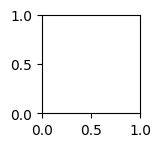

In [50]:
plot_samples(X_train, y_train, labels, 20)
# plot_samples([1], [3],[2], 1)
# print(X_train, y_train, labels)